# **Import**

In [10]:
import warnings

warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

# !pip install catboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# !pip install optuna
import optuna

from sklearn.metrics import mean_absolute_error, mean_squared_error

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [7]:
cum_stat_train_df = pd.read_csv('./cum_stat_train_FD004.csv')
cum_stat_test_df = pd.read_csv('./cum_stat_test_FD004.csv')
rul_df = pd.read_csv('./RUL_FD004.csv')

In [8]:
results = {}

using_sensors = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
stat_cols = [col for col in cum_stat_train_df.columns if col.startswith('s_')]
setting_group = [col for col in cum_stat_train_df.columns if col.startswith('setting_group')]

# **Hyperparameter Tuning**

## **RandomForest**

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()

train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

train_x_sample, _, train_y_sample, _ = train_test_split(
    train_x, train_y, test_size=0.5, random_state=42
)

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    score = -np.mean(cross_val_score(model, train_x_sample, train_y_sample, cv=2, scoring='neg_mean_absolute_error'))
    return score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=20)

In [13]:
print("Best RF params:", study_rf.best_params)

Best RF params: {'n_estimators': 111, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7204143533272397}


In [14]:
best_rf_params = study_rf.best_params
rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    random_state=42,
    n_jobs=-1
)
rf_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_rf = rf_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_rf = mean_absolute_error(true, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(true, pred_rf))
results['RandomForest'] = {'MAE': mae_rf, 'RMSE': rmse_rf}
print(f'MAE: {mae_rf}, RMSE: {rmse_rf}')

MAE: 13.642572044481305, RMSE: 19.031633420183525


## **LightGBM**

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()

train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

train_x_sample, _, train_y_sample, _ = train_test_split(
    train_x, train_y, test_size=0.5, random_state=42
)

def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMRegressor(**params)
    score = -np.mean(cross_val_score(model, train_x_sample, train_y_sample, cv=2, scoring='neg_mean_absolute_error'))
    return score

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=20)

In [16]:
print("Best LGBM params:", study_lgb.best_params)

Best LGBM params: {'num_leaves': 195, 'max_depth': 16, 'learning_rate': 0.03522752257235068, 'n_estimators': 712, 'subsample': 0.5440966947783852, 'colsample_bytree': 0.5538889821212839}


In [17]:
best_lgb_params = study_lgb.best_params
lgb_model = LGBMRegressor(**best_lgb_params)
lgb_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_lgb = lgb_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_lgb = mean_absolute_error(true, pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(true, pred_lgb))
results['LightGBM'] = {'MAE': mae_lgb, 'RMSE': rmse_lgb}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24433
[LightGBM] [Info] Number of data points in the train set: 61000, number of used features: 113
[LightGBM] [Info] Start training from score 92.854508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [18]:
print(f'MAE: {mae_lgb}, RMSE: {rmse_lgb}')

MAE: 13.005329346446922, RMSE: 18.214959347924083


## **CatBoost**

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()

train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

train_x_sample, _, train_y_sample, _ = train_test_split(
    train_x, train_y, test_size=0.5, random_state=42
)

def objective_cat(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'verbose': 0,
        'random_state': 42
    }
    model = CatBoostRegressor(**params)
    score = -np.mean(cross_val_score(model, train_x_sample, train_y_sample, cv=2, scoring='neg_mean_absolute_error'))
    return score

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=20)

In [20]:
print("Best CatBoost params:", study_cat.best_params)

Best CatBoost params: {'depth': 10, 'learning_rate': 0.061445374629996746, 'iterations': 1838, 'l2_leaf_reg': 4.191215188164813, 'bagging_temperature': 0.654947771823592}


In [ ]:
best_cat_params = study_cat.best_params
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_cat = cat_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_cat = mean_absolute_error(true, pred_cat)
rmse_cat = np.sqrt(mean_squared_error(true, pred_cat))
results['CatBoost'] = {'MAE': mae_cat, 'RMSE': rmse_cat}

In [22]:
print(f'MAE: {mae_cat}, RMSE: {rmse_cat}')

MAE: 13.098915875456745, RMSE: 18.19630310108786


## **LSTM**

In [23]:
stat_setting_cols = stat_cols + setting_group

def make_cum_train_sequence_data(df, seq_len):
    x, y = [], []

    for unit in df['unit_number'].unique():
        unit_df = df[df['unit_number'] == unit]
        sensor_values = unit_df[stat_setting_cols].values
        rul_values = unit_df['RUL'].values

        for i in range(len(unit_df) - seq_len + 1):
            x.append(sensor_values[i:i + seq_len])
            y.append(rul_values[i + seq_len - 1])

    return np.array(x), np.array(y)

def make_cum_test_sequence_data(df, seq_len):
    x = []
    unit_list = df['unit_number'].unique()

    for unit in unit_list:
        unit_df = df[df['unit_number'] == unit]
        values = unit_df[stat_setting_cols].values

        if len(unit_df) >= seq_len:
            x.append(values[-seq_len:])
        else:
            pad = np.repeat(values[-1:], seq_len - len(unit_df), axis=0)
            x.append(np.vstack([pad, values]))

    return np.array(x)

In [24]:
def build_lstm_model(seq_len, n_features, hidden_dim, dropout):
    model = Sequential([
        LSTM(hidden_dim, input_shape=(seq_len, n_features)),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

In [ ]:
train_x_stats = cum_stat_train_df[stat_cols].copy()
train_x_settings = cum_stat_train_df[setting_group].copy()
test_x_stats = cum_stat_test_df[stat_cols].copy()
test_x_settings = cum_stat_test_df[setting_group].copy()

scaler = StandardScaler()
scaler.fit(train_x_stats)

train_x_stats = scaler.transform(train_x_stats)
test_x_stats = scaler.transform(test_x_stats)

scaled_train_df = pd.DataFrame(
    np.concatenate([train_x_stats, train_x_settings], axis=1),
    columns=stat_setting_cols
)
scaled_train_df['unit_number'] = cum_stat_train_df['unit_number'].values

train_rul_df = cum_stat_train_df.copy()
train_rul_df.loc[train_rul_df['RUL'] > 125, 'RUL'] = 125
scaled_train_df['RUL'] = train_rul_df['RUL'].values

scaled_test_df = pd.DataFrame(
    np.concatenate([test_x_stats, test_x_settings], axis=1),
    columns=stat_setting_cols
)
scaled_test_df['unit_number'] = cum_stat_test_df['unit_number'].values

train_x, train_y = make_cum_train_sequence_data(scaled_train_df, 50)
test_x = make_cum_test_sequence_data(scaled_test_df, 50)

def objective_lstm(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    model = build_lstm_model(50, n_features=train_x.shape[2], hidden_dim=hidden_dim, dropout=dropout)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

    history = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=0)
    val_mae = min(history.history['val_mae'])
    return val_mae

study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=20)

In [26]:
print("Best LSTM params:", study_lstm.best_params)

Best LSTM params: {'hidden_dim': 35, 'dropout': 0.20413566285973545, 'lr': 0.004526318157387068, 'batch_size': 23}


In [27]:
best_lstm_params = study_lstm.best_params
hidden_dim = best_lstm_params['hidden_dim']
dropout = best_lstm_params['dropout']
lr = best_lstm_params['lr']
batch_size = best_lstm_params['batch_size']

lstm_model = build_lstm_model(50, n_features=train_x.shape[2], hidden_dim=hidden_dim, dropout=dropout)
lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
lstm_model.fit(train_x, train_y, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)

pred_lstm = lstm_model.predict(test_x).flatten()
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_lstm = mean_absolute_error(true, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(true, pred_lstm))
results['LSTM'] = {'MAE': mae_lstm, 'RMSE': rmse_lstm}

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [28]:
print(f'MAE: {mae_lstm}, RMSE: {rmse_lstm}')

MAE: 16.148109436035156, RMSE: 22.892476727577037


## **Result**

In [29]:
results_df = pd.DataFrame(results).T
results_df['RMSE-MAE'] = results_df['RMSE'] - results_df['MAE']
results_df

,MAE,RMSE,RMSE-MAE
RandomForest,13.642572,19.031633,5.389061
LightGBM,13.005329,18.214959,5.209630
CatBoost,13.098916,18.196303,5.097387
LSTM,16.148109,22.892477,6.744367


# **Error Correlation**

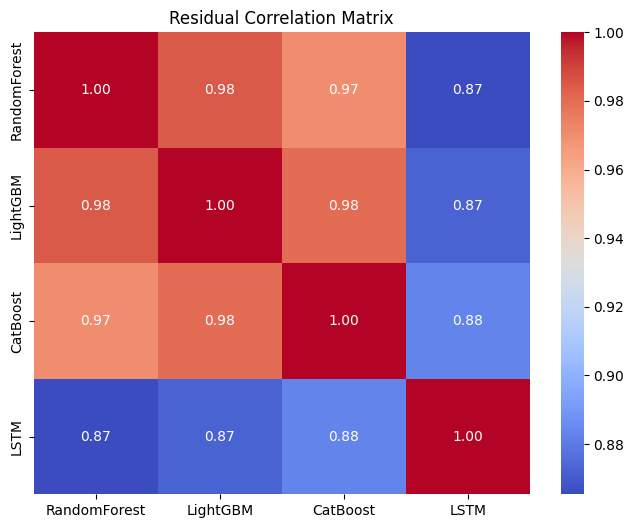

In [30]:
# 오차 벡터 생성
true = rul_df['RUL'].values.ravel()
errors = pd.DataFrame({
    'RandomForest': true - pred_rf,
    'LightGBM': true - pred_lgb,
    'CatBoost': true - pred_cat,
    'LSTM': true - pred_lstm
})

# 상관관계 계산
corr_matrix = errors.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Residual Correlation Matrix")
plt.show()

# **Ensemble**

In [31]:
ensemble_results = {}

def make_cum_val_sequence_data(df, seq_len):
    x, y = [], []
    unit_list = df['unit_number'].unique()

    for unit in df['unit_number'].unique():
        unit_df = df[df['unit_number'] == unit]
        sensor_values = unit_df[stat_setting_cols].values
        rul_values = unit_df['RUL'].values

        x.append(sensor_values[-seq_len:])
        y.append(rul_values[-1])

    return np.array(x), np.array(y)

In [36]:
train_df = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 200].copy()
val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 200].copy()

train_x_stats = train_df[stat_cols].copy()
train_x_settings = train_df[setting_group].copy()
val_x_stats = val_df[stat_cols].copy()
val_x_settings = val_df[setting_group].copy()
test_x_stats = cum_stat_test_df[stat_cols].copy()
test_x_settings = cum_stat_test_df[setting_group].copy()

scaler = StandardScaler()
scaler.fit(train_x_stats)

train_x_stats = scaler.transform(train_x_stats)
val_x_stats = scaler.transform(val_x_stats)
test_x_stats = scaler.transform(test_x_stats)

scaled_train_df = pd.DataFrame(
    np.concatenate([train_x_stats, train_x_settings], axis=1),
    columns=stat_setting_cols
)
scaled_train_df['unit_number'] = train_df['unit_number'].values

train_rul_df = train_df.copy()
train_rul_df.loc[train_rul_df['RUL'] > 125, 'RUL'] = 125
scaled_train_df['RUL'] = train_rul_df['RUL'].values

scaled_val_df = pd.DataFrame(
    np.concatenate([val_x_stats, val_x_settings], axis=1),
    columns=stat_setting_cols
)
scaled_val_df['unit_number'] = val_df['unit_number'].values

val_rul_df = val_df.copy()
val_rul_df.loc[val_rul_df['RUL'] > 125, 'RUL'] = 125
scaled_val_df['RUL'] = val_rul_df['RUL'].values

scaled_test_df = pd.DataFrame(
    np.concatenate([test_x_stats, test_x_settings], axis=1),
    columns=stat_setting_cols
)
scaled_test_df['unit_number'] = cum_stat_test_df['unit_number'].values

train_x_lstm, train_y_lstm = make_cum_train_sequence_data(scaled_train_df, 50)
val_x_lstm, val_y_lstm = make_cum_val_sequence_data(scaled_val_df, 50)
test_x_lstm = make_cum_test_sequence_data(scaled_test_df, 50)

best_lstm_params = study_lstm.best_params
hidden_dim = best_lstm_params['hidden_dim']
dropout = best_lstm_params['dropout']
lr = best_lstm_params['lr']
batch_size = best_lstm_params['batch_size']

lstm_model = build_lstm_model(50, n_features=train_x_lstm.shape[2], hidden_dim=hidden_dim, dropout=dropout)
lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
lstm_model.fit(train_x_lstm, train_y_lstm, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)

pred_lstm_val = lstm_model.predict(val_x_lstm).flatten()
pred_lstm_test = lstm_model.predict(test_x_lstm).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## **RandomForest + LSTM**

In [37]:
train_df = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 200].copy()
val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 200].copy()

train_x_rf = train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y_rf = train_df['RUL'].copy()
val_x_rf = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_rf = val_df.groupby('unit_number')['RUL'].tail(1).copy()

train_y_rf.loc[train_y_rf > 125] = 125
train_y_rf = train_y_rf.values.ravel()
val_y_rf.loc[val_y_rf > 125] = 125
val_y_rf = val_y_rf.values.ravel()

best_rf_params = study_rf.best_params
rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    random_state=42,
    n_jobs=-1
)
rf_model.fit(train_x_rf, train_y_rf)

pred_rf_val = rf_model.predict(val_x_rf)

test_x_rf = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()
pred_rf_test = rf_model.predict(test_x_rf)

In [ ]:
def objective(trial):
    w_rf = trial.suggest_float("w_rf", 0.0, 1.0)
    w_lstm = 1.0 - w_rf

    pred_ensemble = w_rf * pred_rf_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_rf, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [39]:
print("Best weights:", best_weights)

Best weights: {'w_rf': 0.18640227006561932}


In [40]:
best_w = study.best_params['w_rf']
pred_ensemble_test = best_w * pred_rf_test + (1-best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_rf = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_rf = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['RandomForest + LSTM'] = {'MAE': mae_rf, 'RMSE': rmse_rf}
print(f"Ensemble weight (RF): {best_w:.3f}")
print(f"Test MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}")

Ensemble weight (RF): 0.186
Test MAE: 26.217, RMSE: 35.084


## **LightGBM + LSTM**

In [ ]:
train_df = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 200].copy()
val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 200].copy()

train_x_lgb = train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y_lgb = train_df['RUL'].copy()
val_x_lgb = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_lgb = val_df.groupby('unit_number')['RUL'].tail(1).copy()

train_y_lgb.loc[train_y_lgb > 125] = 125
train_y_lgb = train_y_lgb.values.ravel()
val_y_lgb.loc[val_y_lgb > 125] = 125
val_y_lgb = val_y_lgb.values.ravel()

best_lgb_params = study_lgb.best_params
lgb_model = LGBMRegressor(**best_lgb_params)
lgb_model.fit(train_x_lgb, train_y_lgb)

pred_lgb_val = lgb_model.predict(val_x_lgb)

test_x_lgb = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()
pred_lgb_test = lgb_model.predict(test_x_lgb)

In [ ]:
def objective(trial):
    w_lgb = trial.suggest_float("w_lgb", 0.0, 1.0)
    w_lstm = 1.0 - w_lgb

    pred_ensemble = w_lgb * pred_lgb_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_lgb, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [43]:
print("Best weights:", best_weights)

Best weights: {'w_lgb': 0.5297234526697282}


In [44]:
best_w = study.best_params['w_lgb']
pred_ensemble_test = best_w * pred_lgb_test + (1-best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_lgb = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_lgb = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['LightGBM + LSTM'] = {'MAE': mae_lgb, 'RMSE': rmse_lgb}
print(f"Ensemble weight (lgb): {best_w:.3f}")
print(f"Test MAE: {mae_lgb:.3f}, RMSE: {rmse_lgb:.3f}")

Ensemble weight (lgb): 0.530
Test MAE: 23.827, RMSE: 32.497


## **CatBoost + LSTM**

In [ ]:
train_df = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 200].copy()
val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 200].copy()

train_x_cat = train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y_cat = train_df['RUL'].copy()
val_x_cat = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_cat = val_df.groupby('unit_number')['RUL'].tail(1).copy()

train_y_cat.loc[train_y_cat > 125] = 125
train_y_cat = train_y_cat.values.ravel()
val_y_cat.loc[val_y_cat > 125] = 125
val_y_cat = val_y_cat.values.ravel()

best_cat_params = study_cat.best_params
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(train_x_cat, train_y_cat)

pred_cat_val = cat_model.predict(val_x_cat)

test_x_cat = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()
pred_cat_test = cat_model.predict(test_x_cat)

In [ ]:
def objective(trial):
    w_cat = trial.suggest_float("w_cat", 0.0, 1.0)
    w_lstm = 1.0 - w_cat

    pred_ensemble = w_cat * pred_cat_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_cat, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [54]:
print("Best weights:", best_weights)

Best weights: {'w_cat': 0.0009437080705434683}


In [55]:
best_w = study.best_params['w_cat']
pred_ensemble_test = best_w * pred_cat_test + (1-best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_cat = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_cat = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['Catboost + LSTM'] = {'MAE': mae_cat, 'RMSE': rmse_cat}
print(f"Ensemble weight (cat): {best_w:.3f}")
print(f"Test MAE: {mae_cat:.3f}, RMSE: {rmse_cat:.3f}")

Ensemble weight (cat): 0.001
Test MAE: 27.653, RMSE: 36.630


## **Result**

In [49]:
results_df = pd.DataFrame(ensemble_results).T
results_df['RMSE-MAE'] = results_df['RMSE'] - results_df['MAE']
results_df

,MAE,RMSE,RMSE-MAE
RandomForest + LSTM,26.217034,35.083977,8.866944
LightGBM + LSTM,23.827196,32.496967,8.669771
Catboost + LSTM,27.659523,36.637783,8.978260
